# Imports

In [1]:
import os
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
import pytorch_lightning as pl

c:\Users\gabri\miniconda3\envs\ds_gpu\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
import rsna_atd.config as config
from rsna_atd.models import CT_3DModel
from rsna_atd.data import LoadingDataset, max_shape_pad
from rsna_atd.utils import split_group, SimpleLogger
from rsna_atd.visualization import plot_per_task_accuracy, plot_loss, get_best_epoch

In [3]:
DATASET_PATH = "../rsna-2023-abdominal-trauma-detection"
INPUT_PATH = "D://rsna-atd-2voxel-float16"

In [4]:
import torch
torch.set_float32_matmul_precision('medium')

In [5]:
config.EPOCHS = 10
config.TEST_SIZE = 0.0

# Dataloader

In [6]:
meta_df = pd.read_csv(f"{DATASET_PATH}/train_series_meta.csv")
aortic_hues = meta_df["aortic_hu"].to_numpy()

In [7]:
from sklearn.preprocessing import StandardScaler

ah_normalizer = StandardScaler().fit(aortic_hues.reshape(-1, 1))

In [8]:
label_df = pd.read_csv(f"{DATASET_PATH}/train.csv")
label_df["filepath"] = f"data_"+ label_df["patient_id"].astype(str) + ".pt"

In [9]:
data_paths = [os.path.join(INPUT_PATH, data_filename) for data_filename in os.listdir(INPUT_PATH) if data_filename.endswith('.pt')]

In [10]:
len(data_paths)

3147

In [11]:
len(label_df)

3147

In [12]:
label_df["path"] = data_paths

In [13]:
df = label_df

In [14]:
# Initialize the train and validation datasets
train_df = pd.DataFrame()
val_df = pd.DataFrame()

# This is different from TARGET_COLS, as otherwise
# there is redundancy in groups
GROUP_COLS  = [
    "bowel_injury", "extravasation_injury",
    "kidney_healthy", "kidney_low", "kidney_high",
    "liver_healthy", "liver_low", "liver_high",
    "spleen_healthy", "spleen_low", "spleen_high",
]

# Iterate through the groups and split them, handling single-sample groups
for _, group in df.groupby(GROUP_COLS):
    train_group, val_group = split_group(group, test_size=config.TEST_SIZE)
    train_df = pd.concat([train_df, train_group], ignore_index=True)
    val_df = pd.concat([val_df, val_group], ignore_index=True)
    
train_data_paths = train_df["path"].to_list()
if config.TEST_SIZE > 0.0:
    val_data_paths = val_df["path"].to_list()
else:
    val_data_paths = []

In [15]:
import torch
from monai.transforms import Compose, ScaleIntensity, NormalizeIntensity, ToTensor

transform = Compose([
    ScaleIntensity(minv=0.0, maxv=10000.0),
    NormalizeIntensity(
                       nonzero=True # Only normalize non-zero values
                      ),
    ToTensor(track_meta=False, wrap_sequence=False, dtype=torch.float16),
])

In [16]:
def train_no_collate_fn(batch):
    x = [b[0] for b in batch]
    x = max_shape_pad(x)
    aortic_hu = [b[1] for b in batch]
    target = torch.tensor(np.stack([b[2] for b in batch]))
    return x, aortic_hu, target

In [17]:
from monai.transforms import (
    RandAffine,
    RandRotate,
    RandGaussianNoise,
)

augment = Compose([
    RandAffine(prob=0.5, translate_range=10),
    RandRotate(prob=0.5, range_x=10.0),
    RandGaussianNoise(prob=0.5),
])

In [18]:
train_ds = LoadingDataset(train_data_paths, ah_normalizer=ah_normalizer, augment=augment, transform=transform) 
val_ds = LoadingDataset(val_data_paths, ah_normalizer=ah_normalizer, transform=transform)

train_dl, val_dl = DataLoader(train_ds, shuffle=True, collate_fn=train_no_collate_fn), DataLoader(val_ds, collate_fn=train_no_collate_fn)

# Train

In [19]:
logger = SimpleLogger()

In [20]:
# # Instantiate the Lightning model
# model = CT_3DModel()

# # Instantiate the Trainer and train the model
# trainer = pl.Trainer(max_epochs=config.EPOCHS, accelerator="auto", logger=logger,
#                      precision="16-mixed", # mixed precission
#                     #  accumulate_grad_batches=config.BATCH_SIZE, # virtual BATCH_SIZE
# #                      gradient_clip_val=1e-1,
# #                      detect_anomaly=True
#                     )

In [21]:
# from pytorch_lightning.tuner import Tuner

# # Create a Tuner
# tuner = Tuner(trainer)

# # finds learning rate automatically
# # sets hparams.lr or hparams.learning_rate to that learning rate
# lr_finder = tuner.lr_find(model, train_dataloaders=train_dl, min_lr = 1e-20, max_lr = 1)

In [22]:
# # # Results can be found in
# print(lr_finder.results)

# # Plot with
# fig = lr_finder.plot(suggest=True)
# fig.show()

# # # Pick point based on plot, or get suggestion
# new_lr = lr_finder.suggestion()

In [23]:
# new_lr = lr_finder.suggestion()
# new_lr

In [24]:
# Instantiate the Lightning model
new_lr = 1e-2
model = CT_3DModel(lr = new_lr)

# Instantiate the Trainer and train the model
trainer = pl.Trainer(max_epochs=config.EPOCHS, accelerator="auto", logger=logger,
                     precision="16-mixed", # mixed precission
                     accumulate_grad_batches=config.BATCH_SIZE, # virtual BATCH_SIZE
                     gradient_clip_val=1e-1,
                     detect_anomaly=True
                    )
trainer.fit(model, train_dl, val_dl)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


c:\Users\gabri\miniconda3\envs\ds_gpu\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory e:\PersonalProjects\Kaggle\RSNA-ATD\notebooks\CustomLogger\0\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
c:\Users\gabri\miniconda3\envs\ds_gpu\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

  | Name           | Type         | Params
------------------------------------------------
0 | loss_functions | ModuleDict   | 0     
1 | backbone       | EfficientN

Sanity Checking: 0it [00:00, ?it/s]

c:\Users\gabri\miniconda3\envs\ds_gpu\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\gabri\miniconda3\envs\ds_gpu\Lib\site-packages\pytorch_lightning\utilities\data.py:103: UserWarning: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

c:\Users\gabri\miniconda3\envs\ds_gpu\Lib\site-packages\pytorch_lightning\utilities\data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
`Trainer.fit` stopped: `max_epochs=10` reached.


# Visualize Results

e:\personalprojects\kaggle\rsna-atd\rsna_atd\visualization.py:31: UserWarning: No validation bowel accuracy found.
  warnings.warn(f'No validation {name} accuracy found.')
e:\personalprojects\kaggle\rsna-atd\rsna_atd\visualization.py:31: UserWarning: No validation extra accuracy found.
  warnings.warn(f'No validation {name} accuracy found.')
e:\personalprojects\kaggle\rsna-atd\rsna_atd\visualization.py:31: UserWarning: No validation kidney accuracy found.
  warnings.warn(f'No validation {name} accuracy found.')
e:\personalprojects\kaggle\rsna-atd\rsna_atd\visualization.py:31: UserWarning: No validation liver accuracy found.
  warnings.warn(f'No validation {name} accuracy found.')
e:\personalprojects\kaggle\rsna-atd\rsna_atd\visualization.py:31: UserWarning: No validation spleen accuracy found.
  warnings.warn(f'No validation {name} accuracy found.')


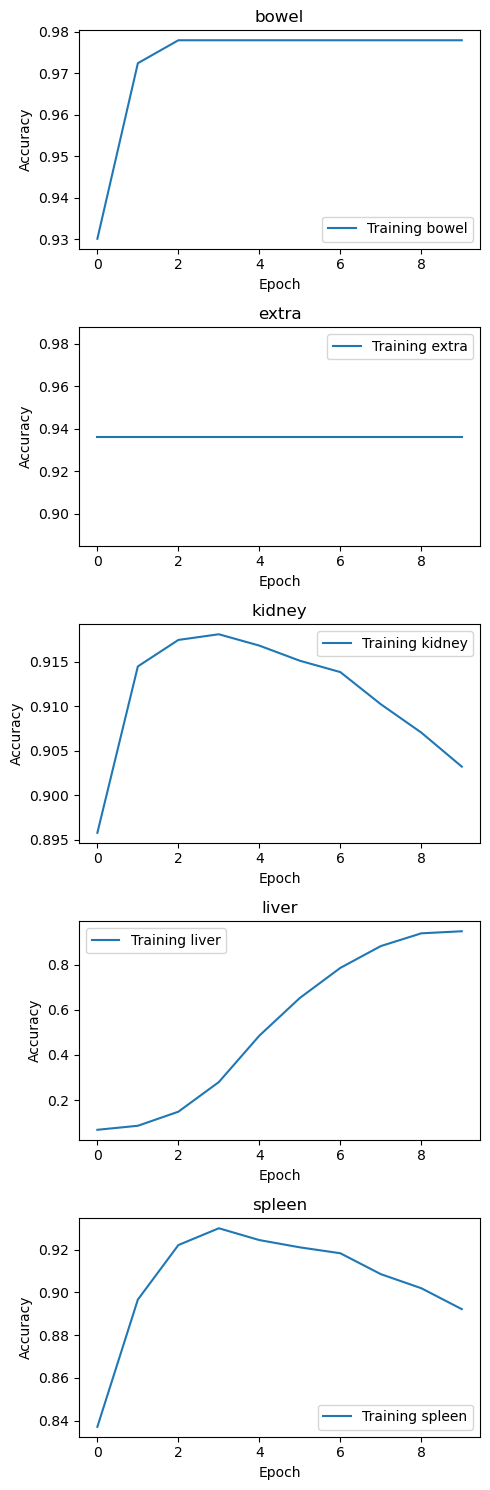

In [25]:
plot_per_task_accuracy(logger)

e:\personalprojects\kaggle\rsna-atd\rsna_atd\visualization.py:45: UserWarning: No validation loss found.
  warnings.warn('No validation loss found.')


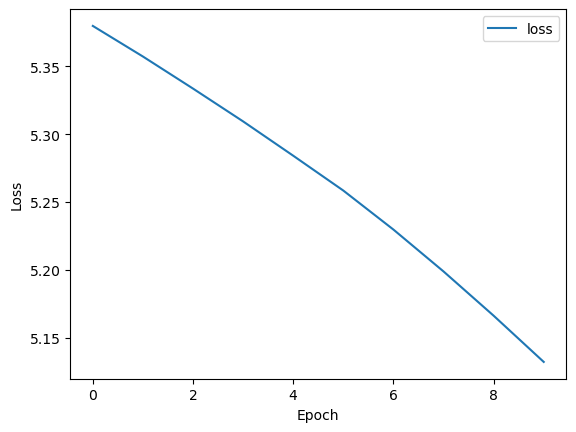

In [26]:
plot_loss(logger)

In [27]:
get_best_epoch(logger)

>>>> BEST Loss  : 5.132
>>>> BEST Acc   : 0.931
>>>> BEST Epoch : 9

ORGAN Acc:
  >>>> Bowel           : 0.978
  >>>> Extravasation   : 0.936
  >>>> Liver           : 0.948
  >>>> Kidney          : 0.903
  >>>> Spleen          : 0.892


e:\personalprojects\kaggle\rsna-atd\rsna_atd\visualization.py:62: UserWarning: No validation loss found. Using training loss instead
  warnings.warn('No validation loss found. Using training loss instead')


# Save Model

In [28]:
# Save the PyTorch model
SAVE_PATH = "rsna-atd_ct_3d.pth"
trainer.save_checkpoint(SAVE_PATH)